In [7]:
import numpy as np
import nibabel as nib
import os
import pickle
import dipy.viz.regtools as rt
from dipy.align import VerbosityLevels
from dipy.align.transforms import regtransforms
from dipy.align.imaffine import (AffineMap,
                                 transform_centers_of_mass,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.imwarp import (SymmetricDiffeomorphicRegistration)
from dipy.align.metrics import (CCMetric)
from scipy.ndimage.morphology import binary_dilation
import experiments.registration.dataset_info as info
%matplotlib inline

In [2]:
try:
    from experiments.registration.regviz import overlay_slices_with_contours
except:
    from dipy.viz.regtools import overlay_slices as overlay_slices_with_contours

def dipy_align(static, static_grid2world, moving, moving_grid2world):
    r''' Full rigid registration with Dipy's imaffine module
    
    Here we implement an extra optimization heuristic: move the geometric
    centers of the images to the origin. Imaffine does not do this by default
    because we want to give the user as much control of the optimization
    process as possible.

    '''
    # Bring the center of the moving image to the origin
    c_moving = tuple(0.5 * np.array(moving.shape, dtype=np.float64))
    c_moving = moving_grid2world.dot(c_moving+(1,))
    correction_moving = np.eye(4, dtype=np.float64)
    correction_moving[:3,3] = -1 * c_moving[:3]
    centered_moving_aff = correction_moving.dot(moving_grid2world)

    # Bring the center of the static image to the origin
    c_static = tuple(0.5 * np.array(static.shape, dtype=np.float64))
    c_static = static_grid2world.dot(c_static+(1,))
    correction_static = np.eye(4, dtype=np.float64)
    correction_static[:3,3] = -1 * c_static[:3]
    centered_static_aff = correction_static.dot(static_grid2world)
    
    dim = len(static.shape)
    metric = MutualInformationMetric(nbins=32, sampling_proportion=0.3)
    level_iters = [10000, 1000, 100]
    affr = AffineRegistration(metric=metric, level_iters=level_iters)
    affr.verbosity = VerbosityLevels.DEBUG
    #metric.verbosity = VerbosityLevels.DEBUG
    
    # Registration schedule: center-of-mass then translation, then rigid and then affine
    prealign = 'mass'
    transforms = ['TRANSLATION', 'RIGID', 'AFFINE']
    
    sol = np.eye(dim + 1)
    for transform_name in transforms:
        transform = regtransforms[(transform_name, dim)]
        print('Optimizing: %s'%(transform_name,))
        x0 = None
        sol = affr.optimize(static, moving, transform, x0,
                              centered_static_aff, centered_moving_aff, starting_affine = prealign)
        prealign = sol.affine.copy()

    # Now bring the geometric centers back to their original location
    fixed = np.linalg.inv(correction_moving).dot(sol.affine.dot(correction_static))
    sol.set_affine(fixed)
    sol.domain_grid2world = static_grid2world
    sol.codomain_grid2world = moving_grid2world
    
    return sol

def check_neonate_atlas():
    names = ['infant-neo.nii', 'infant-neo-aal.nii', 'infant-neo-avgseg.nii', 'infant-neo-seg.nii']
    neo_nib = nib.load('infant-neo.nii')
    neo = neo_nib.get_data()
    neo_affine = neo_nib.get_affine()
    rt.plot_slices(neo)

    neo_aal_nib = nib.load('infant-neo-aal.nii')
    neo_aal = neo_aal_nib.get_data()
    neo_aal_affine = neo_aal_nib.get_affine()
    rt.plot_slices(neo_aal)

    neo_avgseg_nib = nib.load('infant-neo-avgseg.nii')
    neo_avgseg = neo_avgseg_nib.get_data()
    neo_avgseg_affine = neo_avgseg_nib.get_affine()
    rt.plot_slices(neo_avgseg)

    neo_with_cerebellum_nib = nib.load('infant-neo-withCerebellum.nii')
    neo_with_cerebellum = neo_with_cerebellum_nib.get_data()
    neo_with_cerebellum_affine = neo_with_cerebellum_nib.get_affine()
    rt.plot_slices(neo_with_cerebellum)

    neo_with_skull_nib = nib.load('infant-neo-withSkull.nii')
    neo_with_skull = neo_with_skull_nib.get_data()
    neo_with_skull_affine = neo_with_skull_nib.get_affine()
    rt.plot_slices(neo_with_skull)

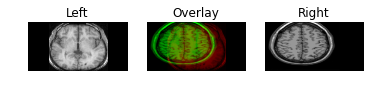

In [14]:
ibsr1_name = info.get_ibsr(1, 'raw')
ibsr1_nib = nib.load(ibsr1_name)
ibsr1 = ibsr1_nib.get_data().squeeze()
ibsr1_affine = ibsr1_nib.get_affine()

# Load brainweb (and match ibsr axes)
brainweb_strip_name = info.get_brainweb('t1','strip')
brainweb_strip_nib = nib.load(brainweb_strip_name)
brainweb_strip = brainweb_strip_nib.get_data().squeeze()
brainweb_strip = brainweb_strip.transpose([0,2,1])[::-1,:,:]
brainweb_mask = brainweb_strip>0

brainweb_name = info.get_brainweb('t1','raw')
brainweb_nib = nib.load(brainweb_name)
brainweb = brainweb_nib.get_data().squeeze()
brainweb_affine = brainweb_nib.get_affine()
brainweb = brainweb.transpose([0,2,1])[::-1,:,:]
brainweb_affine = ibsr1_affine.copy()
brainweb_affine[brainweb_affine!=0] = 1
brainweb_affine[0,0] = -1



# Reslice Brainweb on IBSR1
ibsr_to_bw = AffineMap(None, ibsr1.shape, ibsr1_affine, brainweb.shape, brainweb_affine)
bw_on_ibsr1 = ibsr_to_bw.transform(brainweb)
rt.overlay_slices(ibsr1, bw_on_ibsr1); # misaligned

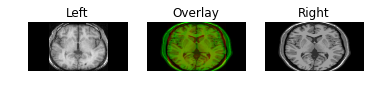

In [15]:
c_of_mass = transform_centers_of_mass(ibsr1, ibsr1_affine, brainweb, brainweb_affine)
bw_on_ibsr1 = c_of_mass.transform(brainweb)
rt.overlay_slices(ibsr1, bw_on_ibsr1); # roughly aligned

In [19]:
diff_name = 'ibsr1_to_brainweb_diff.p'
if os.path.isfile(diff_name):
    ibsr_bw_diffmap = pickle.load(open(diff_name,'r'))
else:
    metric = CCMetric(3)
    level_iters = [100, 10]
    sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)
    sdr.verbosity = VerbosityLevels.DEBUG
    ibsr_bw_diffmap = sdr.optimize(ibsr1, brainweb, ibsr1_affine, brainweb_affine, ibsr_bw_affmap.affine)
    pickle.dump(ibsr_bw_diffmap, open(diff_name,'w'))

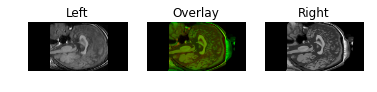

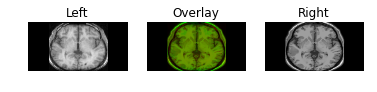

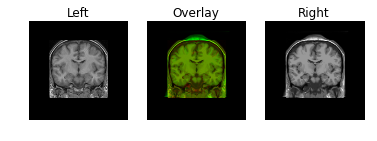

In [20]:
bw_warped_ibsr1 = ibsr_bw_diffmap.transform(brainweb)
overlay_slices_with_contours(ibsr1, bw_warped_ibsr1, slice_type=0); # warped (sagital view)
overlay_slices_with_contours(ibsr1, bw_warped_ibsr1, slice_type=1); # warped (axial view)
overlay_slices_with_contours(ibsr1, bw_warped_ibsr1, slice_type=2); # warped (coronal view)

In [21]:
# Now the initial segmentation
bw_mask_ibsr1 = ibsr_bw_diffmap.transform(brainweb_mask)
bw_mask_ibsr1 = bw_mask_ibsr1>0

# Dilate
structure = np.ones((5,5,5))
dilated_mask = binary_dilation(bw_mask_ibsr1, structure)

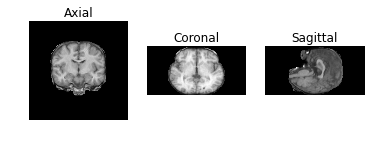

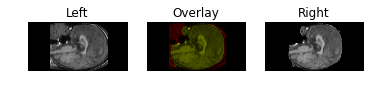

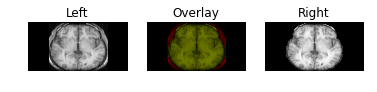

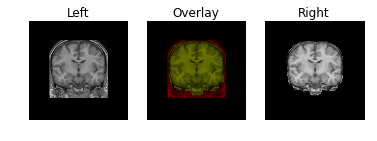

In [23]:
ibsr1_strip_init = ibsr1 * dilated_mask
rt.plot_slices(ibsr1_strip_init)
overlay_slices_with_contours(ibsr1, ibsr1_strip_init, slice_type=0); # warped (sagital view)
overlay_slices_with_contours(ibsr1, ibsr1_strip_init, slice_type=1); # warped (axial view)
overlay_slices_with_contours(ibsr1, ibsr1_strip_init, slice_type=2); # warped (coronal view)